# Visualization Example

Here, we follow the steps explained in [scene](./scene.ipynb) to visualize the sparse or dense point clouds of the COLMAP reconstruction and generate a [3D visualization](https://sketchfab.com/3d-models/3d-tracking-a-calibration-wand-c40e4a353949426fa025ba7e10c13a9f) of the calibration wand tracks.

First, we initialize everything as already shown, but additionally, also load the COLMAP dense scene for plotting the dense point cloud.

In [1]:
import sys
sys.path.append('../..')

import MultiViewTracks as mvt
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

In [2]:
# copy dense scene to model path (otherwise sparse point cloud will be loaded)
!cp ./data/dense/fused_cleanded.ply ./data/sparse

In [3]:
scene = mvt.Scene(model_path='/media/paul/Samsung_T5/revision/20190624-stick-0/sparse',
                  tracks_path='/media/paul/Samsung_T5/revision/20190624-stick-0/tracks',
                  fisheye=False,
                  verbose=False)
scene.get_pointcloud()
condition = scene.extrinsics['FRAME_IDX'] < scene.extrinsics['FRAME_IDX'].max() - 450
scene.extrinsics = {key: scene.extrinsics[key][condition] for key in scene.extrinsics}
scene.get_cameras()
scene.interpolate_cameras()
scene.triangulate_multiview_tracks()
scene.project_singleview_tracks()
scene.get_tracks_3d()

camera_ids = [1, 3]
world_distance = 0.6

reconstruction_errors = scene.scale(camera_ids, world_distance)
scene.rotate()

Linearly interploate the 3D tracks for visualization purposes, so that we ensure all frames have both ends of the calibration wand tracked.

In [4]:
tracks_interpolated = mvt.tracks.interpolate_tracks(scene.tracks_3d)

Create lists of points for later visualization. Here we extract both ends of the wand every 60 frames, starting from frame 10.

In [5]:
pts_2d = []
pts = []
for idx in tracks_interpolated['FRAME_IDX'][10::60]:
    if not np.all([np.isin(idx, tracks_interpolated[str(i)]['FRAME_IDX']) for i in tracks_interpolated['IDENTITIES']]):
        continue
    pts_3d = [np.transpose([tracks_interpolated[str(i)]['X'][tracks_interpolated[str(i)]['FRAME_IDX'] == idx],
                            tracks_interpolated[str(i)]['Y'][tracks_interpolated[str(i)]['FRAME_IDX'] == idx],
                            tracks_interpolated[str(i)]['Z'][tracks_interpolated[str(i)]['FRAME_IDX'] == idx]]) \
              for i in tracks_interpolated['IDENTITIES']]
    pts_2d.append(np.array(pts_3d)[:, :, :2].reshape(2, 2))
    pts.append(np.array(pts_3d))

Let's plot it on top of the dense COLMAP reconstruction (the scatter plot takes some time).

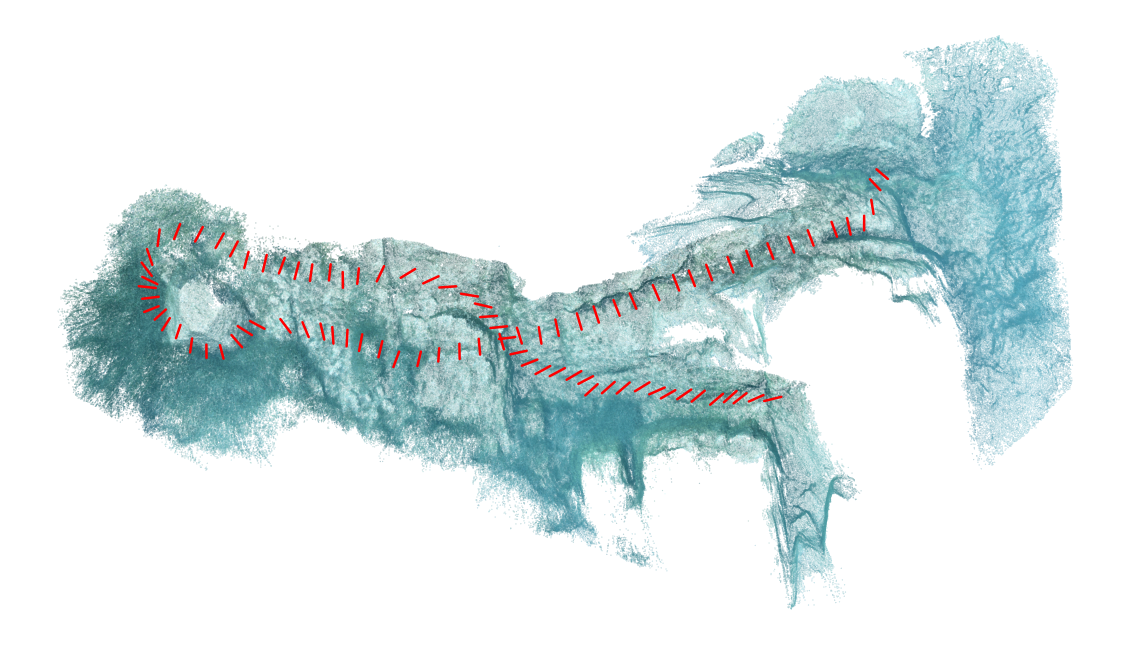

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.axes.axis('off')
ax.scatter(scene.point_cloud[:, 0], scene.point_cloud[:, 1], s=0.02, c=scene.point_cloud[:, 3:] / 255)
lc = ax.plot(*np.transpose(pts_2d), c='r', lw=2.5, solid_capstyle='round')
ax.set_aspect('equal');

In order to visualize the wand in a 3D point cloud, we need to interpolate the 3D points between both ends of the wand for every frame we want to visualize.

In [7]:
pts = np.array(pts).reshape(-1, 2, 3)
x = pts[:, :, 0]
y = pts[:, :, 1]
z = pts[:, :, 2]
x_interpolated = []
y_interpolated = []
z_interpolated = []
for component, component_interpolated in zip([x, y, z], [x_interpolated, y_interpolated, z_interpolated]):
    for idx in range(component.shape[0]):
        component_interpolated.append(np.interp(np.linspace(0, 1, 100), np.array((0, 1)), component[idx, :]))
x_interpolated = np.array(x_interpolated)
y_interpolated = np.array(y_interpolated)
z_interpolated = np.array(z_interpolated)

Finally, we create a numpy array in the same format as the COLMAP reconstruction we loaded above, and write it to a .ply file. The same applies to the reconstruction, since we rotated and scaled the pointcloud.

In [8]:
pts_interpolated = np.transpose([x_interpolated, y_interpolated, z_interpolated]).reshape(-1, 3)
rgb = np.zeros_like(pts_interpolated)
rgb[:, 0] = 255
point_cloud = np.append(pts_interpolated, rgb, axis=1)
mvt.utils.write_ply(mvt.utils.pointcloud_to_ply(point_cloud),
                    file_name='./data/dense/visualization_calibration_wand.ply')
mvt.utils.write_ply(mvt.utils.pointcloud_to_ply(scene.point_cloud),
                    file_name='./data/dense/visualization_reconstruction.ply')

We use [meshlab](http://www.meshlab.net/) to load both the above created .ply files and flatten the mesh layers. The result of this example can be found on [scetchfab](https://sketchfab.com/3d-models/3d-tracking-a-calibration-wand-c40e4a353949426fa025ba7e10c13a9f).